## Navigate to the Correct Directory

The following code navigates to the dataprocessing directory.

In [1]:
cd ../dataprocessing

/usr/local/google/home/carverforbes/activity-recognition/location/lbs/activity/audioset/dataprocessing


## Call the Import Statements

The following code imports the necessary code to run the code in the rest of this notebook.

In [2]:
# import statements
import audio_processing as ap

import functools
import os
import sys
import datetime
import gc

from absl import logging
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow import feature_column
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import sklearn

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Ran the import statements.")

Ran the import statements.


## Feature Extraction
Configure the following parameters to extract the desired features from a specified csv file to a specific destination directory.

In [3]:
# set logging to print logging.INFO logs
logging.set_verbosity(logging.INFO)

In [4]:
# arguments for audio_processing
src_dir = 'example_src_dir'
dest_dir = 'example_dest_dir'
filename = 'gunshot_50_50'
notebook = 'training_melspectrogram_cnn'
labels = ['Gunshot, gunfire']
available_features = ['chroma_stft',
                       'chroma_cqt',
                       'chroma_cens',
                       'melspectrogram',
                       'mfcc',
                       'rms',
                       'spectral_centroid',
                       'spectral_bandwidth',
                       'spectral_contrast',
                       'spectral_flatness',
                       'spectral_rolloff',
                       'poly_features',
                       'tonnetz',
                       'zero_crossing_rate']
features_to_extract = ['melspectrogram']
last_features = None
redo = False

In [ ]:
# Import the dataset as a pandas DataFrame object.
features = '_'.join(features_to_extract)
csv_path = os.path.join(dest_dir, filename + '_' + features + '.csv')
features_changed = last_features is None or features_to_extract != last_features
last_features = features_to_extract
df = ap.output_df(src_dir, dest_dir, filename, labels, features_to_extract, redo)

In [6]:
# print the first 5 rows of the dataframe.
df.head()

,label,melspectrogram
0,1,"[[3.4134238, 2.5367897, 2.295652, 1.9729736, 1..."
1,1,"[[0.009715517, 0.0028677727, 0.001311192, 0.00..."
2,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1,"[[0.17823805, 0.099924825, 0.043443326, 0.1058..."
4,0,"[[0.0009629534, 0.0006072721, 0.00039850635, 0..."


## Data Preprocessing

In [7]:
def fix_dataframe(dataframe):
    # temp bug fix for rows with None features
    # and rows with different number of elements per frame
    bad_rows = []
    for i in dataframe.index:
        if dataframe.melspectrogram[i] is None:
            bad_rows.append(i)
        elif dataframe.melspectrogram[i][0] is None:
            bad_rows.append(i)
        elif len(dataframe.melspectrogram[i]) != 128:
            bad_rows.append(i)
        elif len(dataframe.melspectrogram[i][0]) != 431:
            bad_rows.append(i)
    new_dataframe = dataframe.drop(bad_rows)
    return new_dataframe

In [8]:
# Shuffle the dataset/dataframe.
def shuffle_dataframe(dataframe):
    dataframe = dataframe.reindex(np.random.permutation(dataframe.index))
    return dataframe

In [9]:
def dataframe_to_x_y(dataframe):
    X = np.array(dataframe.melspectrogram.tolist(), dtype=object)
    y = np.array(dataframe.label.tolist())
    
    # Convert arrays of objects to arrays of floats.
    X = tf.keras.backend.cast_to_floatx(X)
    y = tf.keras.backend.cast_to_floatx(y)
    return X, y

In [10]:
def data_preprocessing(dataframe):
    print('tossing bad or incongruent data')
    dataframe = fix_dataframe(dataframe)
    print('shuffling dataframe')
    dataframe = shuffle_dataframe(dataframe)
    print('getting X, y from dataframe')
    X, y = dataframe_to_x_y(dataframe)
    x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state = 42)
    return x_train, y_train, x_val, y_val

In [11]:
data = data_preprocessing(df)
x_train, y_train, x_val, y_val = data

tossing bad or incongruent data
shuffling dataframe
getting X, y from dataframe


Enter your data preprocessing here.

## Building and Training Neural Network

In [12]:
def make_dir(path):
    if not os.path.isdir(path):
        try:
            os.mkdir(path)
        except OSError as error:
            logging.error(error)
            return False
    return True

In [13]:
# Define the plotting function.
def plot_curve(epochs, hist, dest_path, notebook_filename, dataset_filename, list_of_metrics, list_of_hyperparameters):
    """Plot a curve of one or more classification metrics vs. epoch and save it to path."""  
    
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()
    
    make_dir(dest_path)    
    path = os.path.join(dest_path, notebook_filename)
    make_dir(path)
    path = os.path.join(path, dataset_filename)
    make_dir(path)
        
    list_of_hyperparameters_temp = [str(item) for item in list_of_hyperparameters]
    filename = '_'.join(list_of_hyperparameters_temp)
    path = os.path.join(path, filename + '.png')
    plt.savefig(path, bbox_inches='tight')
    
    return plt


print("Defined the plot_curve function.")

Defined the plot_curve function.


## Training 1

In [14]:
# Define the functions that create and train a model.
def create_model(my_learning_rate, my_metrics, optimizer, regularization, regularization_lambda):
    """Create and compile a simple classification model."""
    # Discard any pre-existing version of the model.
    model = None

    model = tf.keras.models.Sequential()
              
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2, input_shape=(128, 431, 1), activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=2, activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Flatten(name='Flatten_1'))
    
    model.add(tf.keras.layers.Dense(units=20, activation=activation,
                                    kernel_regularizer=regularization(regularization_lambda),
                                    name='Hidden_1'))

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid,
                                  name='Output'))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.   
    model.compile(optimizer=optimizer(lr=my_learning_rate),                                                   
                loss=loss,
                metrics=my_metrics)

    return model        
              
def train_model(model, features, label, epochs, label_name,
                batch_size=None, my_validation_split=0.0,
                validation_data=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""

    # The x parameter of tf.keras.Model.fit can be a list of arrays.
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, validation_data=validation_data)
    epochs = history.epoch
    hist = pd.DataFrame(history.history)

    return epochs, hist  

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 430, 16)      80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 215, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 215, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 214, 32)       2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 107, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 107, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 106, 64)       8

351/351 [==============================] - 246s 702ms/step - loss: 0.5016 - accuracy: 0.7518 - precision: 0.8726 - recall: 0.5479 - val_loss: 0.5769 - val_accuracy: 0.7887 - val_precision: 0.7582 - val_recall: 0.7864
Epoch 27/30
351/351 [==============================] - 190s 542ms/step - loss: 0.5009 - accuracy: 0.7587 - precision: 0.8761 - recall: 0.5624 - val_loss: 0.7122 - val_accuracy: 0.7846 - val_precision: 0.7088 - val_recall: 0.8937
Epoch 28/30
351/351 [==============================] - 191s 546ms/step - loss: 0.4901 - accuracy: 0.7599 - precision: 0.8655 - recall: 0.5746 - val_loss: 0.5347 - val_accuracy: 0.7814 - val_precision: 0.8321 - val_recall: 0.6510
Epoch 29/30
351/351 [==============================] - 220s 626ms/step - loss: 0.5105 - accuracy: 0.7549 - precision: 0.8722 - recall: 0.5560 - val_loss: 0.5908 - val_accuracy: 0.8097 - val_precision: 0.7736 - val_recall: 0.8225
Epoch 30/30
351/351 [==============================] - 192s 547ms/step - loss: 0.4943 - accuracy

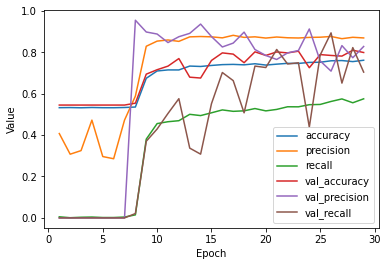

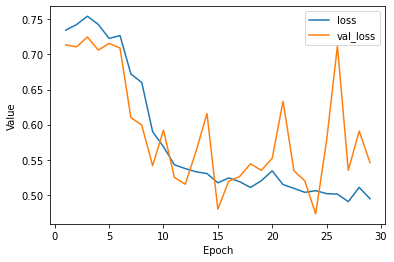

In [15]:
# The following variables are the hyperparameters.
loss = tf.keras.losses.BinaryCrossentropy()
activation = 'relu'
optimizer = tf.keras.optimizers.RMSprop
learning_rate = 0.01
epochs = 30
batch_size = 25
classification_threshold = 0.70
regularization = tf.keras.regularizers.l2
regularization_lambda = 0.001
label_name = "Gunshot, gunfire"

list_of_hyperparameters = [learning_rate, epochs, batch_size,
                           classification_threshold,
                           regularization_lambda,
                           label_name]


# Metrics to measure model performance
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
    tf.keras.metrics.Precision(thresholds=classification_threshold, name='precision'),
    tf.keras.metrics.Recall(thresholds=classification_threshold, name="recall"),
]

x_train1 = x_train.reshape(x_train.shape[0], 128, 431, 1)
x_val1 = x_val.reshape(x_val.shape[0], 128, 431, 1)

# Create model
my_model = create_model(learning_rate, METRICS, optimizer=optimizer, regularization=regularization, regularization_lambda=regularization_lambda)

# View the model's structure.
my_model.summary()

# Train the model on the training set.
epochs, hist = train_model(my_model, x_train1, y_train, epochs, 
                          label_name, batch_size, validation_data=(x_val1, y_val))

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall", 'val_accuracy', 'val_precision', 'val_recall'] 
plot_curve(epochs, hist, dest_dir, notebook, filename, list_of_metrics_to_plot, list_of_hyperparameters)
plot_curve(epochs, hist, dest_dir, notebook, filename, ['loss', 'val_loss'], list_of_hyperparameters)

training_performance =  my_model.evaluate(x_train1, y_train, verbose=0)
print('Training Performance')
print('---------------------------------')
print('loss: ', training_performance[0])
print('accuracy: ', training_performance[1])
print('precision: ', training_performance[2])
print('recall: ', training_performance[3])
print()

validation_performance =  my_model.evaluate(x_val1, y_val, verbose=0)
print('Validation Performance')
print('---------------------------------')
print('loss: ', validation_performance[0])
print('accuracy: ', validation_performance[1])
print('precision: ', validation_performance[2])
print('recall: ', validation_performance[3])

## Training 2

In [16]:
# Define the functions that create and train a model.
def create_model(my_learning_rate, my_metrics, optimizer, regularization, regularization_lambda):
    """Create and compile a simple classification model."""
    # Discard any pre-existing version of the model.
    model = None

    model = tf.keras.models.Sequential()
              
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2, input_shape=(128, 431, 1), activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=2, activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=2, activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Flatten(name='Flatten_1'))
    
    model.add(tf.keras.layers.Dense(units=20, activation=activation,
                                    kernel_regularizer=regularization(regularization_lambda),
                                    name='Hidden_1'))

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid,
                                  name='Output'))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.  
    model.compile(optimizer=optimizer(lr=my_learning_rate),                                                   
                loss=loss,
                metrics=my_metrics)

    return model        
              
def train_model(model, features, label, epochs, label_name,
                batch_size=None, my_validation_split=0.0,
                validation_data=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, validation_data=validation_data)
    epochs = history.epoch
    hist = pd.DataFrame(history.history)

    return epochs, hist  

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


In [ ]:
# The following variables are the hyperparameters.
loss = tf.keras.losses.BinaryCrossentropy()
activation = 'relu'
optimizer = tf.keras.optimizers.RMSprop
learning_rate = 0.01
epochs = 30
batch_size = 25
classification_threshold = 0.70
regularization = tf.keras.regularizers.l2
regularization_lambda = 0.001
label_name = "label"

list_of_hyperparameters = [learning_rate, epochs, batch_size,
                           classification_threshold,
                           regularization_lambda,
                           label_name]


# Here is the updated definition of METRICS:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
    tf.keras.metrics.Precision(thresholds=classification_threshold, name='precision'),
    tf.keras.metrics.Recall(thresholds=classification_threshold, name="recall"),
]

x_train1 = x_train.reshape(x_train.shape[0], 128, 431, 1)
x_val1 = x_val.reshape(x_val.shape[0], 128, 431, 1)

# Create model
my_model = create_model(learning_rate, METRICS, optimizer=optimizer, regularization=regularization, regularization_lambda=regularization_lambda)

# View the model's structure.
my_model.summary()

# Train the model on the training set.
epochs, hist = train_model(my_model, x_train1, y_train, epochs, 
                          label_name, batch_size, validation_data=(x_val1, y_val))

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall", 'val_accuracy', 'val_precision', 'val_recall'] 
plot_curve(epochs, hist, dest_dir, notebook, filename, list_of_metrics_to_plot, list_of_hyperparameters)
plot_curve(epochs, hist, dest_dir, notebook, filename, ['loss', 'val_loss'], list_of_hyperparameters)

training_performance =  my_model.evaluate(x_train1, y_train, verbose=0)
print('Training Performance')
print('---------------------------------')
print('loss: ', training_performance[0])
print('accuracy: ', training_performance[1])
print('precision: ', training_performance[2])
print('recall: ', training_performance[3])
print()

validation_performance =  my_model.evaluate(x_val1, y_val, verbose=0)
print('Validation Performance')
print('---------------------------------')
print('loss: ', validation_performance[0])
print('accuracy: ', validation_performance[1])
print('precision: ', validation_performance[2])
print('recall: ', validation_performance[3])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 127, 430, 16)      80        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 215, 16)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 215, 16)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 214, 32)       2080      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 107, 32)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 31, 107, 32)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 106, 64)      